# Description

In this noteook we train and evaluate TBNNs.

# Import

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from utils import *
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error

# Load data

In [2]:
X_train, X_test = np.load('data/final_data/X_train.npy'), np.load('data/final_data/X_test.npy')
TB_train, TB_test = np.load('data/final_data/TB_train.npy'), np.load('data/final_data/TB_test.npy')
uc_train, uc_test = np.load('data/final_data/uc_train.npy'), np.load('data/final_data/uc_test.npy')
gradc_train, gradc_test = np.load('data/final_data/gradc_train.npy'), np.load('data/final_data/gradc_test.npy')
nut_train, nut_test = np.load('data/final_data/nut_train.npy'), np.load('data/final_data/nut_test.npy')

In [3]:
nut_gradc_train = gradc_train * nut_train.reshape((-1, 1))
nut_gradc_train = nut_gradc_train.reshape((-1, 1, 3))
nut_gradc_test = gradc_test * nut_test.reshape((-1, 1))
nut_gradc_test = nut_gradc_test.reshape((-1, 1, 3))

In [4]:
X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

# Initialize TBNNs

In [5]:
input_features_num = 15
basis_tensors_num = 6
hidden_layers_num = 7
hidden_layer_size = 20

In [6]:
input_layer = layers.Input(shape=(input_features_num),  name='input_layer')
input_tensor_basis = layers.Input(shape=(basis_tensors_num, 3, 3), name='tensor_input_layer')
input_nut_grad_c = layers.Input(shape=(1, 3), name='nut_grad_c')
hidden = layers.Dense(hidden_layer_size,
                      name='hidden_layer_1',
                      kernel_initializer='lecun_normal',
                      kernel_regularizer=tf.keras.regularizers.l2(1E-3),
                      activation = "selu")(input_layer)
for i in range(2, hidden_layers_num+1):
    hidden = layers.Dense(hidden_layer_size,
                          name=f'hidden_layer_{i}',
                          kernel_initializer='lecun_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(1E-3),
                          activation = "selu")(hidden)

gn = layers.Dense(basis_tensors_num,
                  name='gn',
                  kernel_initializer='lecun_normal',
                  kernel_regularizer=tf.keras.regularizers.l2(1E-3),
                  activation = "selu")(hidden)
shaped = layers.Reshape((basis_tensors_num, 1, 1), name='reshape_layer')(gn)
dot_prod_output = layers.Dot(axes=1, name='Dot_product')([shaped,input_tensor_basis])
diffusivity = layers.Reshape((3, 3), name='reshape_output')(dot_prod_output)
output = layers.Dot(axes=2, name='Dot_product_uc')([diffusivity, input_nut_grad_c])



model = keras.Model(inputs=[input_layer, input_tensor_basis, input_nut_grad_c],
                    outputs=[output])
optimizer = tf.keras.optimizers.Nadam(learning_rate = 1e-4, clipnorm=1000)
model.compile(optimizer,loss='mse',metrics=['mae', 'mse'])

reduce_lr =tf.keras.callbacks.ReduceLROnPlateau(
    monitor="loss",
    factor=0.3,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=200,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

2022-06-06 12:16:55.725376: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 12:16:55.830353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 12:16:55.830665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-06 12:16:55.831789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

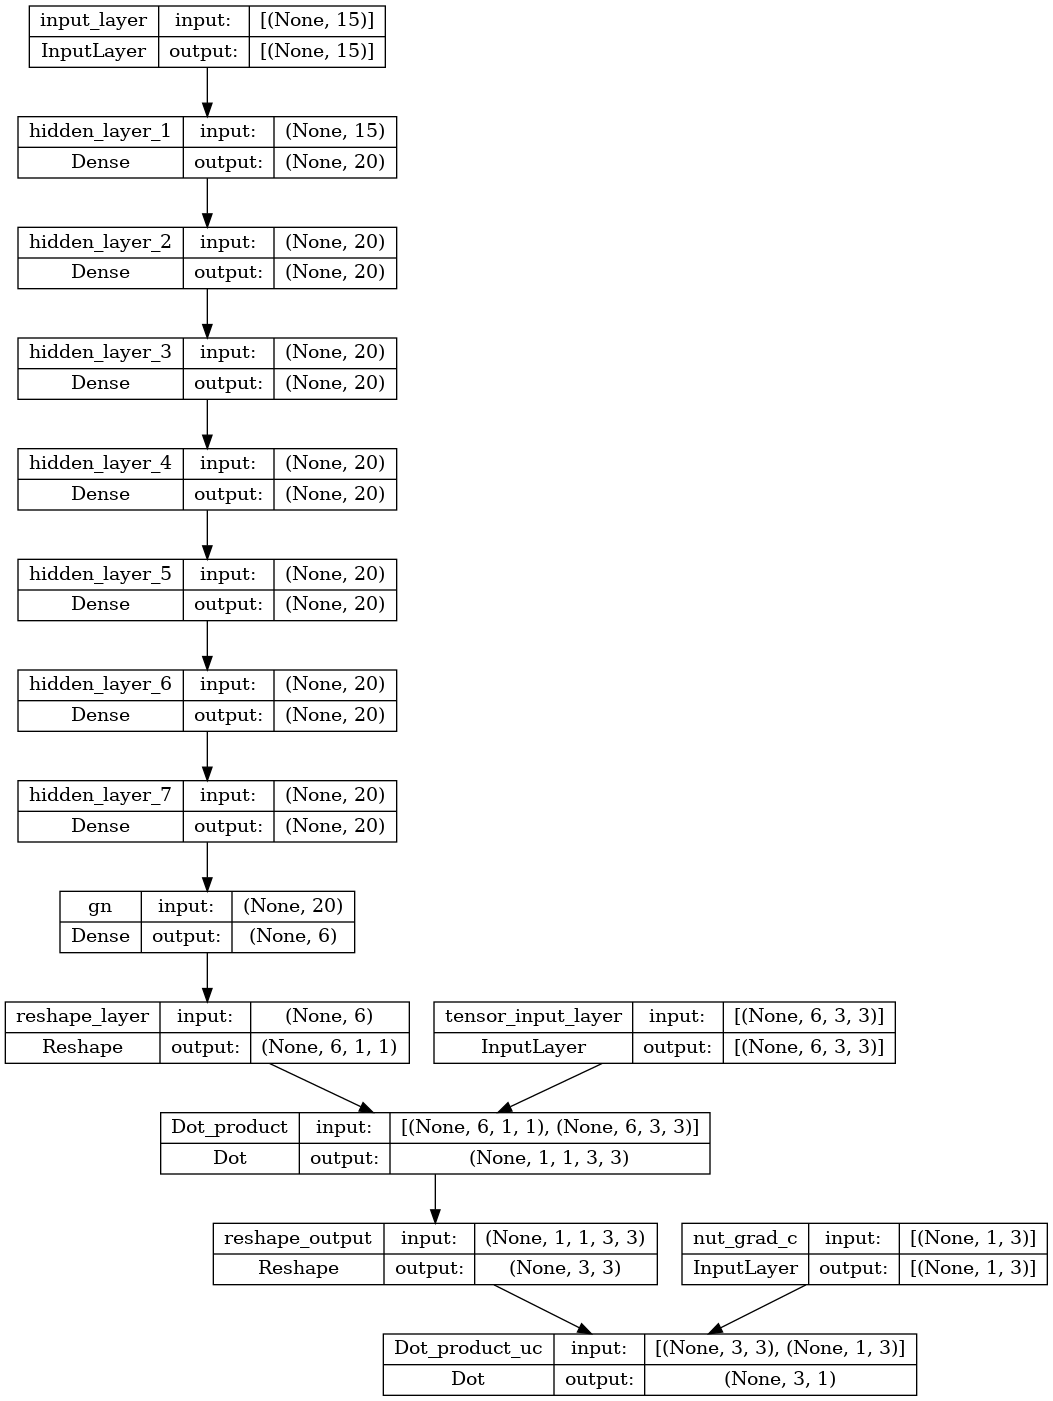

In [85]:
tf.keras.utils.plot_model(model, show_shapes=True,
                          to_file='tbnns_architecture.png')

# Training of TBNNs

In [8]:
history = model.fit([X_train, TB_train, nut_gradc_train], uc_train,
                    batch_size=1000,
                    epochs=10000,
                    validation_data = ([X_test, TB_test, nut_gradc_test], uc_test),
                    verbose=0,
                    callbacks=[early_stop,
                               reduce_lr]
                   )

# Evaluate

In [69]:
uc_pred = model([X_test, TB_test, nut_gradc_test]).numpy()
np.save(f'data/uc_TBNN.npy', uc_pred)

In [70]:
uc_pred = uc_pred.reshape((-1, 3))

In [71]:
c_rans = read_field('C', 10100, 'data/RANS/Re_tau_640_Pr_071/')

In [72]:
c1 = c_rans[:, 0] == 0.025
c2 = c_rans[:, 2] == 0.025
c3 = c_rans[:, 1] <= 1

In [73]:
print('MAE of ut:', mean_absolute_error(uc_test[:, 0], uc_pred[:, 0]))
print('MAE of vt:', mean_absolute_error(uc_test[:, 1], uc_pred[:, 1]))

MAE of ut: 0.25231228165434033
MAE of vt: 0.07301085865074826


# Visualize

## uc

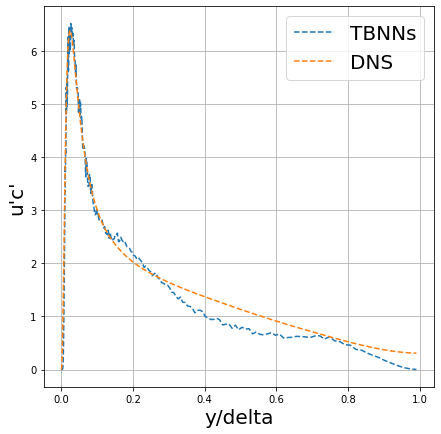

In [74]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred[:, 0], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 0], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("u'c'", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.savefig(f'plots/ut.png', bbox_inches='tight')
plt.savefig(f'plots/ut.pdf', bbox_inches='tight')

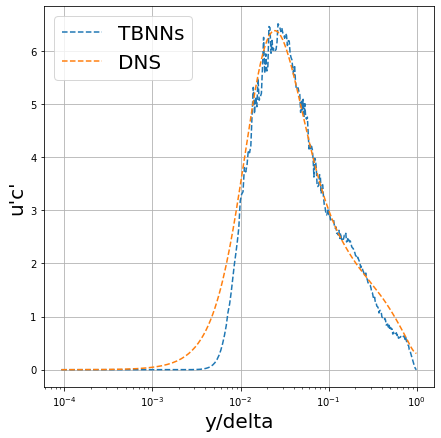

In [75]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred[:, 0], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 0], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("u'c'", fontsize=20)
plt.grid()
plt.xscale('log')
plt.legend(fontsize=20)
plt.savefig(f'plots/ut_log.png', bbox_inches='tight')
plt.savefig(f'plots/ut_log.pdf', bbox_inches='tight')

In [76]:
uc_pred_filt = gaussian_filter1d(uc_pred, 10, axis=0)

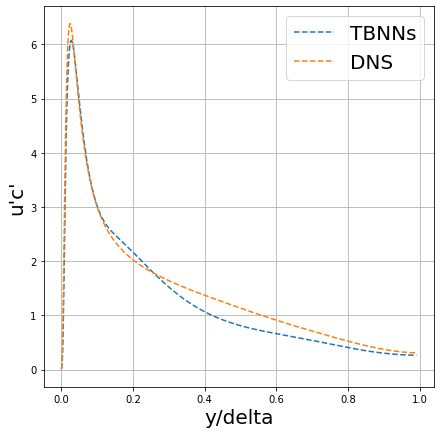

In [77]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred_filt[:, 0], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 0], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("u'c'", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.savefig(f'plots/ut_filt.png', bbox_inches='tight')
plt.savefig(f'plots/ut_filt.pdf', bbox_inches='tight')

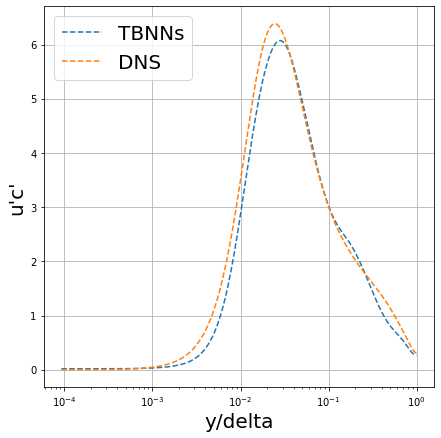

In [78]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred_filt[:, 0], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 0], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("u'c'", fontsize=20)
plt.grid()
plt.xscale('log')
plt.legend(fontsize=20)
plt.savefig(f'plots/ut_filt_log.png', bbox_inches='tight')
plt.savefig(f'plots/ut_filt_log.pdf', bbox_inches='tight')

## vc

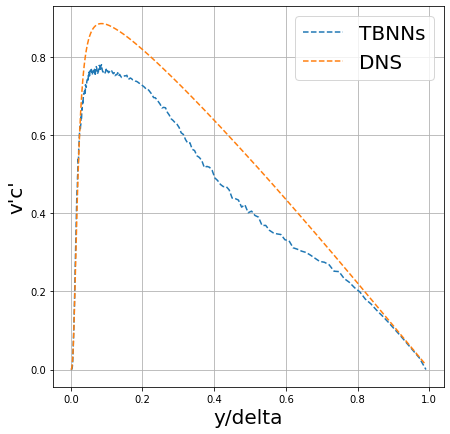

In [79]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred[:, 1], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 1], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("v'c'", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.savefig(f'plots/vt.png', bbox_inches='tight')
plt.savefig(f'plots/vt.pdf', bbox_inches='tight')

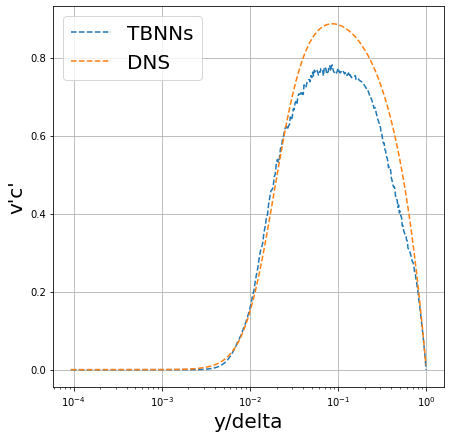

In [80]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred[:, 1], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 1], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("v'c'", fontsize=20)
plt.grid()
plt.xscale('log')
plt.legend(fontsize=20)
plt.savefig(f'plots/vt_log.png', bbox_inches='tight')
plt.savefig(f'plots/vt_log.pdf', bbox_inches='tight')

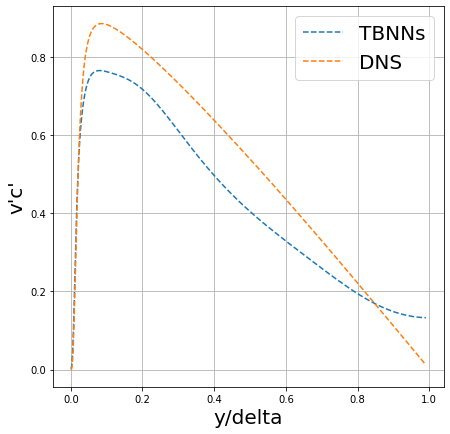

In [81]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred_filt[:, 1], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 1], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("v'c'", fontsize=20)
plt.grid()
plt.legend(fontsize=20)
plt.savefig(f'plots/vt_filt.png', bbox_inches='tight')
plt.savefig(f'plots/vt_filt.pdf', bbox_inches='tight')

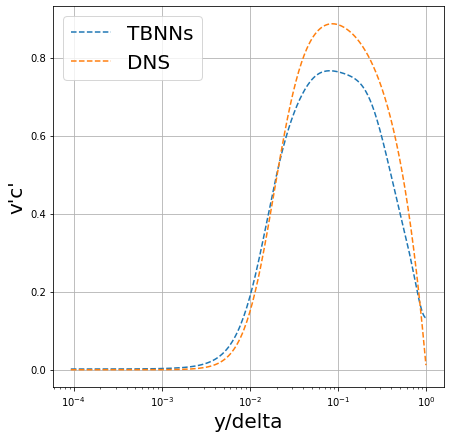

In [82]:
plt.figure(figsize=(7,7))

plt.plot(c_rans[c1 & c2 & c3, 1], uc_pred_filt[:, 1], label='TBNNs', linestyle='dashed')
plt.plot(c_rans[c1 & c2 & c3, 1], uc_test[:, 1], label='DNS', linestyle='dashed')

plt.xlabel('y/delta', fontsize=20)
plt.ylabel("v'c'", fontsize=20)
plt.grid()
plt.xscale('log')
plt.legend(fontsize=20)
plt.savefig(f'plots/vt_filt_log.png', bbox_inches='tight')
plt.savefig(f'plots/vt_filt_log.pdf', bbox_inches='tight')